In [23]:
import pandas as pd   
import numpy as np

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

X = df_train.drop(columns='is_home_run').copy()
y = df_train['is_home_run'].copy()

df_park = pd.read_csv('park_dimensions.csv')
X_merged = X.merge(df_park, on="park", how="left").copy()

columns_to_drop = [
  'park',
  'bip_id',
  'game_date', # Include?
  'home_team', # Include?
  'away_team', # Include?
  'batter_team', # Include?
  'NAME',
  'batter_name', # Include?
  'pitcher_name', # Include?
  'batter_id',
  'pitcher_id',
  'bb_type'
]

cat_vars = [
  'Cover',
  'is_batter_lefty',
  'is_pitcher_lefty',
  'bearing',
  'pitch_name',
  'inning',
  'outs_when_up',
  'balls',
  'strikes',
]

X_merged['launch_speed'] = X_merged['launch_speed'].fillna(0)
X_merged['launch_angle'] = X_merged['launch_angle'].fillna(0)

X = X_merged.drop(columns=columns_to_drop).copy()
X_encoded = pd.get_dummies(X, columns=cat_vars)
print(X_encoded.columns.to_list())

['plate_x', 'plate_z', 'pitch_mph', 'launch_speed', 'launch_angle', 'LF_Dim', 'CF_Dim', 'RF_Dim', 'LF_W', 'CF_W', 'RF_W', 'Cover_Dome', 'Cover_Outdoor', 'Cover_Roof', 'is_batter_lefty_0', 'is_batter_lefty_1', 'is_pitcher_lefty_0', 'is_pitcher_lefty_1', 'bearing_center', 'bearing_left', 'bearing_right', 'pitch_name_4-Seam Fastball', 'pitch_name_Changeup', 'pitch_name_Curveball', 'pitch_name_Cutter', 'pitch_name_Forkball', 'pitch_name_Knuckle Curve', 'pitch_name_Sinker', 'pitch_name_Slider', 'pitch_name_Split-Finger', 'inning_1', 'inning_2', 'inning_3', 'inning_4', 'inning_5', 'inning_6', 'inning_7', 'inning_8', 'inning_9', 'inning_10', 'inning_11', 'inning_12', 'inning_13', 'outs_when_up_0', 'outs_when_up_1', 'outs_when_up_2', 'balls_0', 'balls_1', 'balls_2', 'balls_3', 'strikes_0', 'strikes_1', 'strikes_2']


In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# Create functions
def get_classification_report(model_y_pred, file_name):
  report = classification_report(test_y, model_y_pred, output_dict = True)
  report_df = pd.DataFrame(report)
  display(report_df)
    
  report_df.to_csv(file_name)

  return report_df

def get_and_plot_confusion_matrix(model_y_pred, model, file_name):
  cm = confusion_matrix(test_y, model_y_pred, labels = model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)

  fig, ax = plt.subplots(figsize = (5, 5))
  plt.rcParams.update({'font.size': 12})
  disp.plot(cmap = 'Blues', ax = ax)
  fig.savefig(file_name, bbox_inches = 'tight')

  return cm

def get_and_plot_feature_importance(model, file_name):
  importance = model.feature_importances_
  feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)), columns = ['Feature', 'Importance'])
  feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)
  feature_imp = feature_imp.head(20)
  plt.figure(figsize=(10, 5))
  plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['lightgrey', 'skyblue'])
  plt.xlabel('Importance')
  plt.title('Feature Importance for Fetal Health Predictions') 
  plt.tight_layout()
  plt.savefig(file_name)

  return feature_imp

In [25]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import time
import warnings
warnings.filterwarnings('ignore')

train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size=0.2, random_state=0) 

base_estimator = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(estimator=base_estimator, random_state=0)

ada_clf.fit(train_X, train_y)
y_pred_ada_clf = ada_clf.predict(test_X)

In [26]:
hyper_params = {'estimator__min_samples_leaf': [10, 20, 30, 40, 100],
                'estimator__max_depth': [5,10,13,15],
                'n_estimators': [50, 100, 150]}

folds = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 100)

model_cv = GridSearchCV(estimator = ada_clf,
                        param_grid = hyper_params,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1) 

In [27]:
start = time.time()           
model_cv.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

print('Initial score: ', model_cv.best_score_)
print('Initial parameters: ', model_cv.best_params_)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Training time: 161.93586802482605s
Initial score:  0.9504467226102549
Initial parameters:  {'estimator__max_depth': 13, 'estimator__min_samples_leaf': 100, 'n_estimators': 150}


In [28]:
# Tune hyperparamters
hyper_params_new = {'estimator__min_samples_leaf': list(range(2, 12)),
                    'estimator__max_depth': list(range(15, 24)),
                    'n_estimators': list(range(2, 12))}

# Call GridSearchCV()
model_cv = GridSearchCV(estimator = ada_clf,
                        param_grid = hyper_params_new,
                        scoring= 'f1_weighted',
                        cv = folds,
                        refit=True,
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs

In [29]:
# Fit tuned model
start = time.time()      
model_cv.fit(train_X, train_y)
stop = time.time()           
print(f"Training time: {stop - start}s")

print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

best_ada_clf = model_cv.best_estimator_

y_pred_best_ada_clf = best_ada_clf.predict(test_X)

Fitting 2 folds for each of 900 candidates, totalling 1800 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Training time: 184.50738406181335s
Improved score:  0.9461156221569844
Improved parameters:  {'estimator__max_depth': 22, 'estimator__min_samples_leaf': 2, 'n_estimators': 8}


,0,1,accuracy,macro avg,weighted avg
precision,0.970507,0.400000,0.937507,0.685254,0.941454
recall,0.963431,0.454352,0.937507,0.708892,0.937507
f1-score,0.966956,0.425447,0.937507,0.696202,0.939380
support,8778.000000,471.000000,0.937507,9249.000000,9249.000000


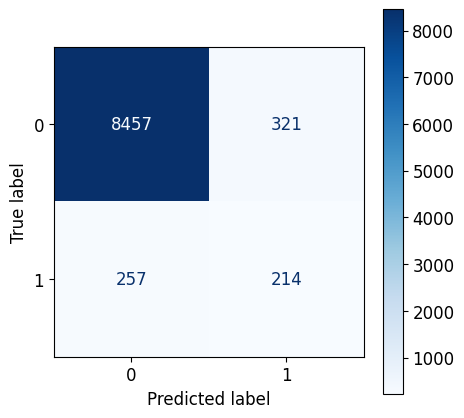

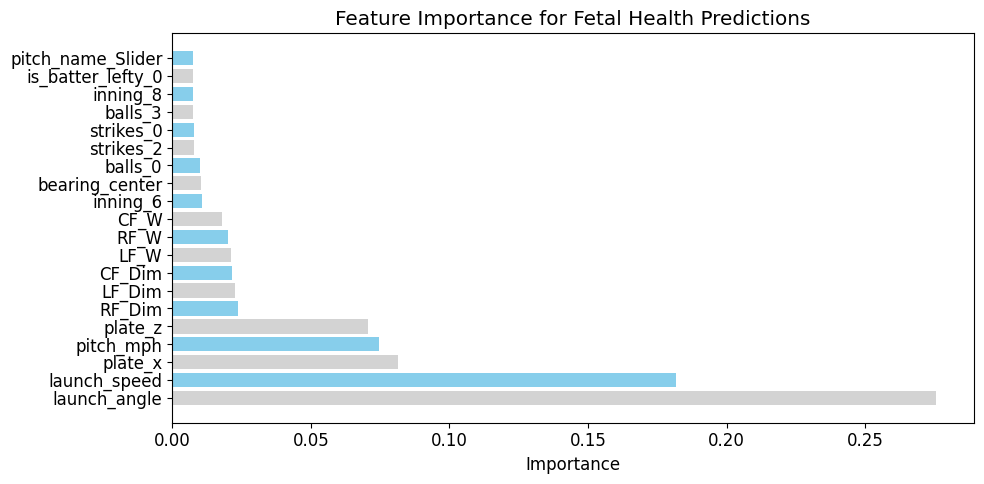

In [34]:

# Get classification report
ada_classification_df = get_classification_report(y_pred_ada_clf, 'class_report_ada.csv')

# Get confusion matrix
ada_cm = get_and_plot_confusion_matrix(y_pred_ada_clf, ada_clf, 'confusion_mat_ada.svg')

# Get feature importance
ada_feature_imp_df = get_and_plot_feature_importance(ada_clf, 'feat_imp_ada.svg')

In [31]:
import pickle

ada_pickle = open('ada.pickle', 'wb') 
pickle.dump(ada_clf, ada_pickle) 
ada_pickle.close()